## Import prepare

In [2]:
import jax
import jax.numpy as jnp
import jax.random as rd
import numpy as np
from functools import partial
from tqdm import tqdm
import matplotlib.pyplot as plt
import optax as optim
import warnings
warnings.simplefilter('ignore')

## 1.Define kernel functions

In [3]:
def k_RBF(x,y,h=1.0):
    return jnp.exp(-1/h*jnp.sum((x-y)**2))

def k_lap(x,y,h=1.0):
    return jnp.exp(-1/h*jnp.sum(jnp.abs(x-y)))

def k_IMQ(x,y,h=1.0):
    return 1/jnp.sqrt(1+jnp.sum((x-y)**2)/(2*h))

def k_linear(x,y,h=1.0):
    return jnp.sum(x*y)

def k_pol(x,y,h=1.0,r=1,n=2):
    return (jnp.sum(x*y)+r)**n


## 2.1 Define target distributions

- banana distriution
$$
y=\left[\begin{array}{l}
y_{1} \\
y_{2}
\end{array}\right] \sim \mathcal{N}\left(0,\left[\begin{array}{cc}
100 & 0 \\
0 & 1
\end{array}\right]\right), \quad x=\left[\begin{array}{c}
y_{1} \\
-y_{2}+b y_{1}^{2}-100 b
\end{array}\right], \quad b=0.1
$$

- neal distribution
$$
x_{1} \sim \mathcal{N}\left(\frac{\sigma^{2}}{4}, \sigma^{2}\right), \quad x_{i} \mid x_{1} \sim \mathcal{N}\left(0, \exp \left(\frac{x_{1}}{2}\right)\right), i\in\{2,3,...,n\},\quad \sigma^{2}=36
$$

- cross distribution
$$
\begin{aligned}
x & \sim \frac{1}{4} \mathcal{N}\left(\left[\begin{array}{l}
0 \\
2
\end{array}\right],\left[\begin{array}{cc}
0.15^{2} & 0 \\
0 & 1
\end{array}\right]\right)+\frac{1}{4} \mathcal{N}\left(\left[\begin{array}{c}
-2 \\
0
\end{array}\right],\left[\begin{array}{cc}
1 & 0 \\
0 & 0.15^{2}
\end{array}\right]\right) \\
&+\frac{1}{4} \mathcal{N}\left(\left[\begin{array}{l}
2 \\
0
\end{array}\right],\left[\begin{array}{cc}
1 & 0 \\
0 & 0.15^{2}
\end{array}\right]\right) +\frac{1}{4} \mathcal{N}\left(\left[\begin{array}{c}
0 \\
-2
\end{array}\right],\left[\begin{array}{cc}
0.15^{2} & 0 \\
0 & 1
\end{array}\right]\right) ;
\end{aligned}
$$

- wraped gaussian distribution

$$
y=\left[\begin{array}{l}
y_{1} \\
y_{2}
\end{array}\right] \sim \mathcal{N}\left(0,\left[\begin{array}{cc}
1 & 0 \\
0 & 0.12^{2}
\end{array}\right]\right), \quad x=\left[\begin{array}{l}
\|y\|_{2} \cos \left(\operatorname{atan} 2\left(y_{2}, y_{1}\right) - \frac{1}{2}\|y\|_{2}\right) \\
\|y\|_{2} \sin \left(\operatorname{atan} 2\left(y_{2}, y_{1}\right) - \frac{1}{2}\|y\|_{2}\right)
\end{array}\right]
$$


In [4]:
def gaussian(x,mu,Sigma):
    '''
    mu: mean
    Sigma: covariance matrix
    '''
    k = x.shape[0]
    Sigma_inv = jnp.linalg.inv(Sigma)
    return 1/jnp.sqrt((2*jnp.pi)**k * jnp.abs(jnp.linalg.det(Sigma))) * jnp.exp(-0.5*(x-mu)@Sigma_inv@(x-mu))

def logp_gaussian_1D(x,mu,sigma2):
    '''
    R^p --> R
    mu: mean
    sigma: variance. 
    '''
    return - jnp.sum((x-mu)**2/(2*sigma2)) - 0.5*jnp.log(sigma2) - jnp.log(jnp.sqrt(2*jnp.pi))


def logp_gaussian_nD(x,mu,Sigma):
    '''
    mu: mean
    Sigma: covariance matrix
    '''
    return -0.5*(x-mu) @ jnp.linalg.inv(Sigma) @ (x-mu)


def logp_neal(x, sigma=6):
    return logp_gaussian_1D(x[0], sigma**2/4, sigma**2) + logp_gaussian_1D(x[1], 0, jnp.exp(0.5*x[0]))




def logp_cross(x):
    '''
        Problem: numerical unstable.
    '''
    m1 = jnp.array([0,2])*1.0
    m2 = jnp.array([-2,0])*1.0
    m3 = jnp.array([2,0])*1.0
    m4 = jnp.array([0,-2])*1.0

    s1 = jnp.array([[0.15**2,0],[0,1]])
    s2 = jnp.array([[1,0],[0,0.15**2]])

    eps = 1e-8
    return jnp.log(1/4*(gaussian(x,m1,s1) + gaussian(x,m2,s2) + gaussian(x,m3,s2) + gaussian(x,m4,s1)) + eps)

def logp_banana(x,b=0.1):
    y = jnp.array([x[0], -b*x[0]**2+x[1]+100*b])
    mu = jnp.array([0,0])
    Sigma = jnp.array([[100,0],[0,1]])*1.0
    return logp_gaussian_nD(y, mu, Sigma)


def logp_warp(x):
    x1 = x[0]
    x2 = x[1]
    norm = jnp.sqrt(x1**2 + x2**2)
    theta = jnp.arctan2(x2,x1) + 0.5*norm
    y1 = norm*jnp.cos(theta)
    y2 = norm*jnp.sin(theta)
    y = jnp.array([y1,y2])
    mu = jnp.array([0,0])
    Sigma = jnp.array([[1,0],[0,0.12**2]])
    return logp_gaussian_nD(y, mu, Sigma)

def logp_cauchy(x,x0,gamma):
    return jnp.log(gamma/jnp.pi/((x-x0)**2 + gamma**2))


logp_gaussian1d_vmap = jax.vmap(logp_gaussian_1D,in_axes=(0,None,0),out_axes=0)
logp_gaussian1d_vmap0 = jax.vmap(logp_gaussian_1D,in_axes=(0,None,None),out_axes=0)

def logp_neal_nD(x,sigma=6):
    x1 = x[1::]
    x0 = x[0]
    return logp_gaussian_1D(x0, sigma**2/4, sigma) + jnp.sum(logp_gaussian1d_vmap0(x1, 0, jnp.exp(0.5*x0)))


## FIXME: design chain distribution

def mean_f(x):
    return 2*jnp.tanh(x)

def variance_g(x):
    return 0*x+1.0

def logp_chain_nD(x,sigma=6,f=mean_f,g=variance_g):
    '''
    x:(p,)
    '''
    x1 = x[1::]
    x0 = x[0:-1]
    return logp_gaussian_1D(x[0], sigma**2/4, sigma**2) + jnp.sum(jax.vmap(logp_gaussian_1D)(x1, f(x0), g(x0)))

def logp_tree_nD(x,sigma=6,f=mean_f,g=variance_g):
    x1 = x[1::]
    x0 = x[0]
    return logp_gaussian_1D(x0, sigma**2/4, sigma**2) + jnp.sum(logp_gaussian1d_vmap0(x1, f(x0), g(x0)))


def get_logp_chain(d,D,f=mean_f,g=variance_g):
    sigma = 6
    if d == 0:
        def logp(xd,x_gammad):
            '''
                xd: ()
                x_gammad: (1,)
            '''
            return logp_gaussian_1D(xd, sigma**2/4, sigma**2) + logp_gaussian_1D(x_gammad[0], f(xd), g(xd))
        return logp
    elif d == D - 1:
        def logp(xd,x_gammad):
            return logp_gaussian_1D(xd, f(x_gammad[0]), g(x_gammad[0]))
        return logp
    else:
        def logp(xd,x_gammad):
            return logp_gaussian_1D(xd, f(x_gammad[0]), g(x_gammad[0])) + logp_gaussian_1D(x_gammad[1], f(xd), g(xd))
        return logp
    

def get_logp_tree(d,D,f=mean_f,g=variance_g):   
    sigma = 6
    
    if d == 0:
        def logp(xd,x_gammad):
            return logp_gaussian_1D(xd, sigma**2/4, sigma**2) + jnp.sum(logp_gaussian1d_vmap0(x_gammad, f(xd), g(xd)))
        return logp
    else:
        def logp(xd,x_gammad):
            return logp_gaussian_1D(xd, f(x_gammad[0]), g(x_gammad[0]))
        return logp
    

    

def MP_structure(D,type='chain',f=mean_f,g=variance_g):
    sigma = 6
    idx_list = []
    logp_list = []
    if type=='chain':
        for d in range(D):
            logp_list.append(get_logp_chain(d,D))
            if d == 0:
                idx_list.append([0,1])
            elif d == D - 1:
                idx_list.append([D - 1,D - 2])
            else:
                idx_list.append([d,d-1,d+1])     
    
    elif type=='tree':
        for d in range(D):
            logp_list.append(get_logp_tree(d,D))
            if d == 0:
                idx_list.append(list(range(D)))
            else:
                idx_list.append([d,0])
    else:
        raise(ValueError)
    
    return logp_list, idx_list


## 2.2 real sampler

In [5]:
def banana_sampler(size=10,seed=123,b=0.1):
    np.random.seed(seed)
    y = np.random.multivariate_normal([0,0],[[100,0],[0,1]],size=size)
    y1 = y[:,0]
    y2 = y[:,1]
    x1 = y1
    x2 = -y2 + b*y1**2- 100*b
    return np.stack([x1,x2],axis=1)

def neal_sampler(size=10,ndim = 2, seed=234,sigma=6):
    np.random.seed(seed)
    x_list = []
    x0 = np.random.normal(sigma**2/4, sigma, size=size)
    
    x_list.append(x0)
    for i in range(ndim-1):
        x_list.append(np.exp(x0/4) * np.random.normal(0,1,size=size))
    return np.stack(x_list, axis=1)

def cross_sampler(size=10,seed=345):
    np.random.seed(seed)
    m1 = np.array([0,2])*1.0
    m2 = np.array([-2,0])*1.0
    m3 = np.array([2,0])*1.0
    m4 = np.array([0,-2])*1.0

    s1 = np.array([[0.15**2,0],[0,1]])
    s2 = np.array([[1,0],[0,0.15**2]])
    N = np.random.multinomial(size,[0.25]*4)
    x1 = np.random.multivariate_normal(m1,s1,size=N[0])
    x2 = np.random.multivariate_normal(m2,s2,size=N[1])
    x3 = np.random.multivariate_normal(m3,s2,size=N[2])
    x4 = np.random.multivariate_normal(m4,s1,size=N[3])

    idx = np.random.permutation(size)

    return np.concatenate([x1,x2,x3,x4],axis=0)[idx]

def warp_sampler(size=10,seed=2323):
    np.random.seed(seed)
    y = np.random.multivariate_normal([0,0],[[1,0],[0,0.12**2]],size=size)
    y1 = y[:,0]
    y2 = y[:,1]

    norm = jnp.sqrt(y1**2 + y2**2)
    theta = jnp.arctan2(y2,y1) - 0.5*norm
    x1 = norm*jnp.cos(theta)
    x2 = norm*jnp.sin(theta)
    return np.stack([x1,x2],axis=1)

def chain_sampler(D, size=10,seed=2312, sigma=6, f=mean_f, g=variance_g):
    assert D > 1
    np.random.seed(seed)
    X = []
    x = np.random.normal(sigma**2/4, sigma, size=size)
    X.append(x)
    for d in range(1,D):
        x = f(x) + np.sqrt(g(x)) * np.random.normal(0,1, size=size)
        X.append(x)
    
    return np.stack(X,axis=1)

def tree_sampler(D, size=10,seed=2312, sigma=6, f=mean_f, g=variance_g):
    assert D > 1
    np.random.seed(seed)
    X = []
    x0 = np.random.normal(sigma**2/4, sigma, size=size)
    X.append(x0)
    for d in range(1,D):
        x = f(x0) + np.sqrt(g(x0)) * np.random.normal(0,1, size=size)
        X.append(x)
    
    return np.stack(X,axis=1)

## 3.1 SVGD definition

In [6]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
from functools import wraps

def get_median_h(X):
    '''
      median trick: A adaptive method to choose h in kernel function.
    '''
    X = jax.device_get(X)
    sq_dist = pdist(X)
    pairwise_dists = squareform(sq_dist)**2
    h = np.median(pairwise_dists)
    h = np.sqrt(0.5 * h / np.log(X.shape[0] + 1))
    return h

def inverse_permutation(idx):
    '''
     fast for numpy array.
     slow for jax array.
    '''
    idx = jax.device_get(idx)
    idy = np.zeros_like(idx,dtype=int)
    for i in range(len(idx)):
        idy[idx[i]] = i
    return jnp.array(idy)


import time
def calc_time(f):
    
    @wraps(f)
    def _f(*args, **kwargs):
        t0 = time.time()
        y = f(*args, **kwargs)
        t1 = time.time()
        print(f' {f.__name__} complete, time cost(s):{t1-t0}')
        return y
    return _f

def jax_get_median_h(X):
    '''
        这个函数比上面这个慢很多，这是什么原因？
    '''
    pairwise_dists = jnp.sum((X[None,:,:] - X[:,None,:])**2,axis=-1)
    h = jnp.median(pairwise_dists)
    h = jnp.sqrt(0.5 * h / jnp.log(X.shape[0] + 1))
    return h

In [7]:

def SVGD_sampler(logp, k, optimizer, batch_size=100, median_trick=True, message_passing=False):
    '''
      Input:
        logp: logrithm function of target distribution.  shape mapping: (p) --> (1)   
        k:    kernel function.                           shape mapping: (p),(p) --> (1)
        optimizer: an optax optimizer.
        batch_size: A interger. mini batch size.
        median_trick: A bool variable. Use adaptive kernel function scale or not.
      Output:
        A SVGD sampler.
    
    '''
    
    s = jax.grad(logp)                    # gradient of logp.     (p) --> (p)
    S = jax.vmap(s,in_axes=0, out_axes=0) # vmap version of s.  (n,p) --> (n,p)
    nabla_k = jax.grad(k, argnums=0)      # gradient of kernel function w.r.t the first arguments of k.


    def outer_op(f):
        '''
        Return a function that is a double vmap version of f.
        Input:  a function f.
          f: (p) , (p), (1) --> (1)
        return: a function F.
          F: (n,p),(n,p),(1) --> (n,n)
        '''
        K1 = jax.vmap(f, in_axes=(0,None,None), out_axes=0)  # (p) x (n,p)  --> n
        K = jax.vmap(K1, in_axes=(None,0,None), out_axes=1) # (n,p) x (n,p) --> (n,n)
        return K


    K = outer_op(k)               # K calculate all interactions between all pairs (xi,xj)
    nabla_K = outer_op(nabla_k)


    def phi(X,h,W):
        '''
        Calculate gradient respect to KL divergence between empirical(X) and target distribution.
        '''
        return  (W*K(X,X,h)) @ S(X) + jnp.sum(W[:,:,None] * nabla_K(X,X,h), axis=0)



    def phi_batch(X,h, idx, idy, W):
        '''
        Calculate gradient respect to KL divergence between empirical(X) and target distribution.
        '''
        N = X.shape[0]

        if batch_size < N:
            p = X.shape[1]
            assert N % batch_size == 0
            n = N//batch_size
            Xp = X[idx]
            Xp = Xp.reshape([n,batch_size,p])
            Yp = jax.vmap(phi, in_axes=(0,None,None), out_axes=(0))(Xp, h, W)
            Yp = Yp.reshape([N,p])
            return Yp[idy]
        else:
            return 1/N*(K(X,X,h) @ S(X) + jnp.sum(nabla_K(X,X,h), axis=0))



    @jax.jit
    def update(X, opt_state, h, idx, idy, weight):
        '''
            update function in SVGD.
        '''
        grads = -phi_batch(X,h,idx,idy,weight)
        updates, opt_state = optimizer.update(grads, opt_state, X)
        X = optim.apply_updates(X, updates)
        return X, opt_state


    @calc_time
    def SVGD(X, iter=1000, batch_rng=rd.PRNGKey(233)):
        '''
        SVGD sampler.
        Input:
          X: initial particles. A jax numpy which has shape (N,p).  N: number of particles.   p: particle dimensions.
          iter: A integer.  The number of iterations.
          batch_rng: [optional]. random seed for stochastic batch division.
        Return:
          samples: A list of samples with length iter.
          samples[i] is a jax numpy which has shape (N,p), the particles at iteration i.
        '''

        samples = []
        opt_state = optimizer.init(X)
        N = X.shape[0]
        
        weight =jnp.ones([batch_size,batch_size])*(N-1)/N/(batch_size-1) + jnp.diag(jnp.ones(batch_size)*(1/N - (N-1)/N/(batch_size-1)))
        h = 1.0
        for i in tqdm(range(iter),desc='sampling'):
            key = rd.fold_in(batch_rng, i)
            idx = rd.permutation(key, N)
            idy = inverse_permutation(idx)
            if median_trick:
                h = get_median_h(X[idx[0:int(N/10)]])
            X, opt_state = update(X, opt_state, h, idx, idy, weight)
            samples.append(jax.device_get(X))
        return samples
    

    return SVGD


## 3.2 SVGD massage passing

In [8]:
def MP_SVGD_sampler(logp_list, k_list, idx_list, optimizer =  optim.adam(learning_rate=0.1), median_trick=True):
    '''
      Input:
        logp: logrithm function of target distribution.  shape mapping: (p) --> (1)   
        k:    kernel function.                           shape mapping: (p),(p) --> (1)
        optimizer: an optax optimizer.
        batch_size: A interger. mini batch size.
        median_trick: A bool variable. Use adaptive kernel function scale or not.
      Output:
        A SVGD sampler.
    
    '''
    D = len(logp_list)

    # logp: () x (p-1) --> ()
    # s: () x (p-1) --> ()
    # S: (n,) x (n,p-1) --> (n,)

    s = [jax.grad(logp_list[d], argnums=0) for d in range(D)]                    # gradient of logp.    () x (p-1) --> ()
    S = [jax.vmap(s[d],in_axes=(0,0), out_axes=0)  for d in range(D)]      # vmap version of s.  (n,) x (n,p-1) --> (n,)

    def get_nablad_K(k):
        # k: (p,) x (p,) --> ()
        def element_K(x_sd, yd, y_gammad, h):
            # (p) x () x (p-1) x () --> ()
            return k(x_sd, jnp.concatenate([yd[...,None],y_gammad],axis=-1), h)
        return jax.grad(element_K, argnums=1)   # (p) x () x (p-1) x () --> ()

    # (p) x () x (p-1) x () --> ()
    nablad_k = [get_nablad_K(k_list[d])  for d in range(D)]      # gradient of kernel function w.r.t the yd of k(x_sd, y_sd).


    def outer_op(f):
        '''
        Return a function that is a double vmap version of f.
        Input:  a function f.
          f: (p) , (p), () --> ()
        return: a function F.
          F: (n,p),(n,p),() --> (n,n)
        '''
        K1 = jax.vmap(f, in_axes=(0,None,None), out_axes=0)  # (n,p) x (p) x ()  --> (n,)
        K = jax.vmap(K1, in_axes=(None,0,None), out_axes=1) # (n,p) x (n,p) x () --> (n,n)
        return K

    def outer_k(f):
        '''
        f: (p) x () x (p-1) x () --> ()
        output: (n,p) x (n,) x (n,p-1) x () --> (n,n)
        '''
        K1 = jax.vmap(f, in_axes=(0,None,None,None), out_axes=0)  # (n,p) x () x (p-1) x ()  --> (n,)
        K = jax.vmap(K1, in_axes=(None,0,0,None), out_axes=1) # (n,p) x (n,) x (n,p-1) x () --> (n,n)
        return K

    # (n,p) x (n,p) --> (n,n)
    K = [outer_op(k_list[d]) for d in range(D)]      

    # (n,p) x (n,) x (n,p-1) x () --> (n,n)
    nablad_K = [outer_k(nablad_k[d]) for d in range(D)] 


    def construct_phi(kernel,nablad_kernel,grad_logp):
        ''' 
        kernel: (n,p),(n,p),() --> (n,n)
        nablad_kernel: (n,p) x (n,) x (n,p-1) x () --> (n,n)
        grad_logp: (n,) x (n,p-1) --> (n,)
        '''
        def phi(xd,x_gammad,h):
            '''
            Calculate gradient respect to KL divergence between empirical(X) and target distribution.
            xd: (n)
            x_gammad: (n,p-1)
            h: ()
            '''
            X = jnp.concatenate([xd[...,None],x_gammad],axis=-1)
            return  1/X.shape[0]*(kernel(X,X,h) @ grad_logp(xd,x_gammad) + jnp.sum(nablad_kernel(X,xd,x_gammad,h), axis=1))

        return phi
    

    phi = [construct_phi(K[d], nablad_K[d], S[d]) for d in range(D)]


    def construct_update(phi,optimizer):
        @jax.jit
        def update(xd,x_gammad,opt_state,h):
            grads = -phi(xd,x_gammad,h)
            updates,opt_state = optimizer.update(grads, opt_state, X)
            return updates, opt_state
        return update

    update = [construct_update(phi[d], optimizer) for d in range(D)]



    @calc_time
    def SVGD(X, iter=1000):
        '''
        SVGD sampler.
        Input:
          X: initial particles. A jax numpy which has shape (N,p).  N: number of particles.   p: particle dimensions.
          iter: A integer.  The number of iterations.
          batch_rng: [optional]. random seed for stochastic batch division.
        Return:
          samples: A list of samples with length iter.
          samples[i] is a jax numpy which has shape (N,p), the particles at iteration i.
        '''

        samples = []
        N = X.shape[0]
        h = 1.0

        opt_state = [optimizer.init(X[:,d]) for d in range(D)]
        for i in tqdm(range(iter),desc='sampling'):
            for d in range(D):
                Sd = idx_list[d]
                xd = X[:,d]
                x_gammad = X[:,Sd[1:]]
                if median_trick:
                    h = get_median_h(X[0:N//10, Sd])
                  
                update_d,opt_state_d = update[d](xd,x_gammad,opt_state[d],h)
                opt_state[d] = opt_state_d
                X = X.at[:,d].add(update_d)
            samples.append(jax.device_get(X))
        return samples
    

    return SVGD


## 3.3 sample quality Estimater

In [14]:
def get_KSD(logp, k):
    # logp: (p) --> () 
    # s: (p) --> (p)
    s = jax.grad(logp, argnums=0) 

    # k: (p) x (p) x () --> ()
    # k0: (p) x (p) x () --> (p)
    # k1: (p) x (p) x () --> (p)
    # kd: (p) x (p) x () --> (p,p)
    k0 = jax.grad(k,argnums=0)
    k1 = jax.grad(k,argnums=1)
    kd = jax.jacobian(k0, argnums=1)

    def up(x,xp,h):
        '''
            (p) x (p) x () --> ()
        '''
        return k(x,xp)*jnp.dot(s(x),s(xp)) + jnp.dot(s(x),k1(x,xp)) + jnp.dot(k0(x,xp), s(xp)) + jnp.trace(kd(x,xp))

    
    def outer_op(f):
        '''
        Return a function that is a double vmap version of f.
        Input:  a function f.
          f: (p) , (p),() --> ()
        return: a function F.
          F: (n,p),(n,p),() --> (n,n)
        '''
        K1 = jax.vmap(f, in_axes=(0,None,None), out_axes=0)  # (p) x (n,p) x () --> (n,)
        K = jax.vmap(K1, in_axes=(None,0,None), out_axes=1) # (n,p) x (n,p) x () --> (n,n)
        return K

    
    Up = outer_op(up)

    @jax.jit
    def KSD(X,h):
        n = X.shape[0]
        U = Up(X,X,h)
        return 1/n/(n-1)*(jnp.sum(U) - jnp.trace(U))


    return KSD

In [11]:
import ite
co = ite.cost.BDKL_KnnK()



def KL_path(samples, truth, exchange=True):
    N = len(samples)
    if exchange:
        s = [co.estimation(samples[i],truth) for i in range(N)]   # This is right !
    else:
        s = [co.estimation(truth, samples[i]) for i in range(N)]
    return s

def mean_variance(X):
    N = X.shape[0]
    m1 = np.mean(X,axis=0)
    m2 = 1/N*X.T@X - m1[:,None] @ m1[None,:]
    return m1,m2

def moment_path(samples, truth):
    N = len(samples)
    ms = [mean_variance(samples[i]) for i in range(N)]
    mt = mean_variance(truth)
    return ms,mt

def show_result(samples,truth,kl,ksd,xlim=(-2,2),ylim=(-4,4)):
    n = -1
    N = samples[n].shape[0]
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.scatter(samples[n][:,0],samples[n][:,1], s=3,label='samples')
    plt.legend()
    plt.subplot(1,2,2)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.scatter(truth[0:N,0],truth[0:N,1], s=3,label='truth')
    plt.legend()
    plt.figure(figsize=(8,4))

    plt.subplot(1,2,1)
    plt.xlabel('iteration')
    plt.ylabel('KL divergence')
    plt.plot(kl)

    plt.subplot(1,2,2)
    plt.xlabel('iteration')
    plt.ylabel('KSD')
    plt.plot(ksd)

## SVGD sampling  

### 1. warp gaussian

sampling: 100%|██████████| 1000/1000 [00:10<00:00, 92.80it/s]


 SVGD complete, time cost(s):10.78457760810852


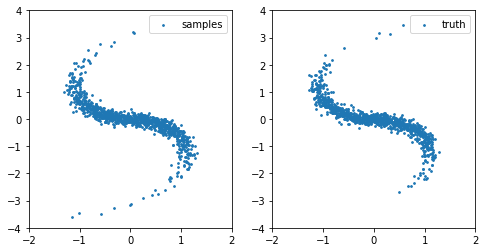

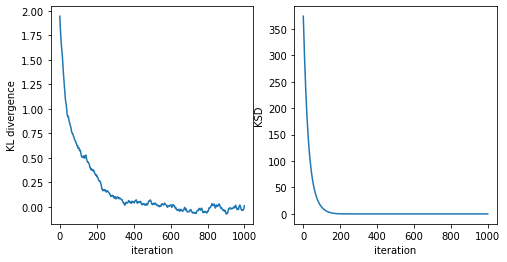

In [15]:
SVGD = SVGD_sampler(logp=logp_warp, k=k_RBF, optimizer=optim.adam(learning_rate=0.01),median_trick=True,batch_size=200)
KSD = get_KSD(logp_warp, k_RBF)
X = rd.normal(rd.PRNGKey(12), (1000,2))
samples = SVGD(X,iter=1000)
truth = warp_sampler(size=1000)
kl = KL_path(samples,truth)
h0 = get_median_h(truth)
ksd = [KSD(samples[i],h0) for i in range(1000)]
show_result(samples, truth, kl,ksd)

### 2.banana distribution

sampling: 100%|██████████| 1000/1000 [00:06<00:00, 158.31it/s]


 SVGD complete, time cost(s):6.338662624359131


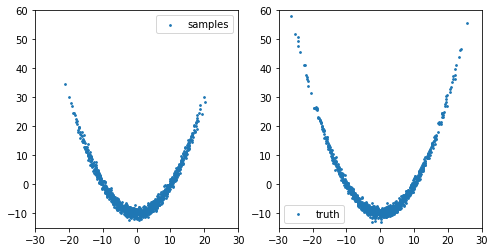

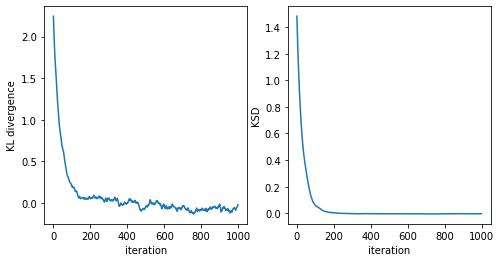

In [28]:
SVGD = SVGD_sampler(logp=logp_banana, k=k_RBF, optimizer=optim.adam(learning_rate=0.1),median_trick=True,batch_size=200)
KSD = get_KSD(logp_banana, k_RBF)
X = rd.normal(rd.PRNGKey(12), (1000,2))*10
samples = SVGD(X,iter=1000)
truth = banana_sampler(size=1000)
kl = KL_path(samples,truth)
h0 = get_median_h(truth)
ksd = [KSD(samples[i],h0) for i in range(1000)]
show_result(samples, truth, kl,ksd,xlim=(-30,30),ylim=(-15,60))

### 3. neal distribution

sampling: 100%|██████████| 1000/1000 [00:08<00:00, 119.75it/s]


 SVGD complete, time cost(s):8.443435192108154


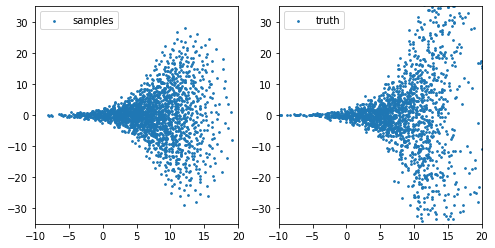

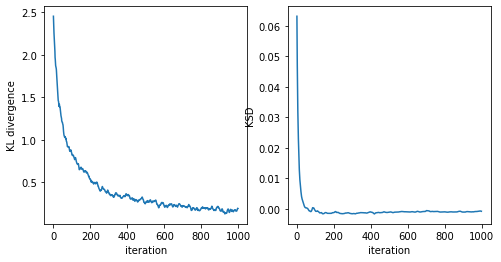

In [27]:
SVGD = SVGD_sampler(logp=logp_neal, k=k_RBF, optimizer=optim.adam(learning_rate=0.1),median_trick=True,batch_size=200)
KSD = get_KSD(logp_neal, k_RBF)
X = rd.normal(rd.PRNGKey(12), (2000,2))*1
samples = SVGD(X,iter=1000)
truth = neal_sampler(size=2000)
kl = KL_path(samples,truth)
h0 = get_median_h(truth)
ksd = [KSD(samples[i],h0) for i in range(1000)]
show_result(samples, truth, kl,ksd,xlim=(-10,20),ylim=(-35,35))

### 4.cross distribution

sampling: 100%|██████████| 1000/1000 [00:07<00:00, 138.95it/s]


 SVGD complete, time cost(s):7.203310966491699


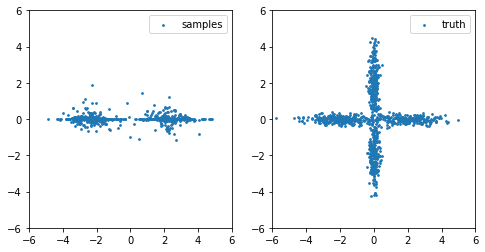

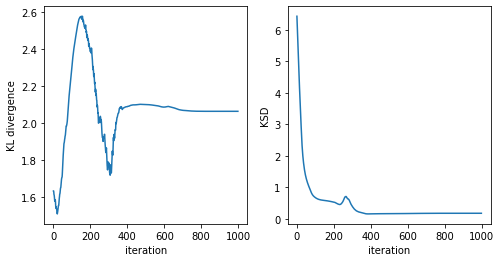

In [26]:
logp,kernel,truth_sampler = logp_cross, k_linear, cross_sampler
xlim,ylim=(-6,6),(-6,6)
SVGD = SVGD_sampler(logp=logp, k=kernel, optimizer=optim.adam(learning_rate=0.01),median_trick=True,batch_size=1000)
KSD = get_KSD(logp, k_RBF)
X = rd.normal(rd.PRNGKey(23), (1000,2))
samples = SVGD(X,iter=1000)
truth = truth_sampler(2000)
kl = KL_path(samples,truth)
h0 = get_median_h(truth)
ksd = [KSD(samples[i],h0) for i in range(1000)]
show_result(samples,truth, kl, ksd, xlim=xlim,ylim=ylim)

## Message Passing

In [176]:
## Difine dims
D = 4
N = 1000
iter = 500
graph_type = 'tree' # 'chain' or 'tree'
if graph_type == 'chain':
    logp_list, idx_list = MP_structure(D,'chain')
    logp = partial(logp_chain_nD,f=mean_f,g=variance_g)
    truth = chain_sampler(D,2000)
else:
    logp_list, idx_list = MP_structure(D,'tree')
    logp = partial(logp_tree_nD,f=mean_f,g=variance_g)
    truth = chain_sampler(D,2000)

In [121]:

## SVGD
SVGD = SVGD_sampler(logp=logp, k=k_RBF, optimizer=optim.adam(learning_rate=0.2),median_trick=True,batch_size=200)
X = rd.normal(rd.PRNGKey(12), (N,D))
samples = SVGD(X,iter=iter)
s = KL_path(samples,truth)


sampling: 100%|██████████| 500/500 [00:05<00:00, 94.85it/s] 


 SVGD complete, time cost(s):5.279604911804199


In [123]:

SVGD = MP_SVGD_sampler(logp_list,[k_RBF]*D,idx_list,median_trick=True ,optimizer=optim.adam(learning_rate=0.2))
X = rd.normal(rd.PRNGKey(12), (N,D))*2
samples_mp = SVGD(X,iter=iter)
s_mp = KL_path(samples_mp,truth)


sampling: 100%|██████████| 500/500 [00:29<00:00, 17.07it/s]


 SVGD complete, time cost(s):29.3082275390625


0.02998227545806742


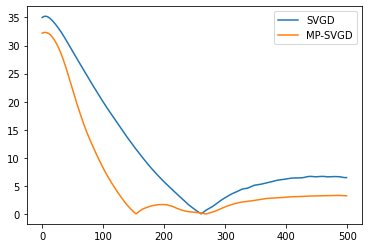

In [119]:
moment_i = 1
idx = (0,0)
ms,mt = moment_path(samples,truth)
ms_mp,mt_mp = moment_path(samples_mp,truth)
l1 = [np.abs(m[moment_i][idx]-mt[moment_i][idx]) for m in ms]
l2 = [np.abs(m[moment_i][idx]-mt_mp[moment_i][idx]) for m in ms_mp]
print(np.min(l1))
plt.plot(l1,label='SVGD')
plt.plot(l2, label='MP-SVGD')
plt.legend()

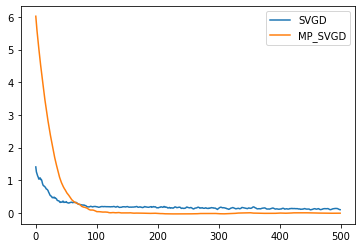

In [177]:
plt.plot(s[0:500],label='SVGD')
plt.plot(s_mp[0:500],label='MP_SVGD')
plt.legend()

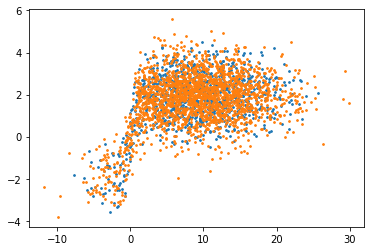

In [114]:
plt.scatter(samples[-1][:,0],samples[-1][:,1],s=3)
plt.scatter(truth[:,0],truth[:,1],s=3)

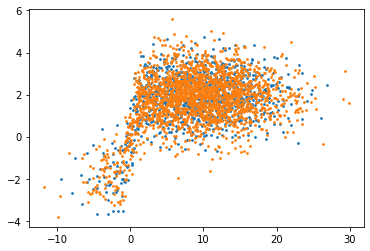

In [115]:
plt.scatter(samples_mp[-1][:,0],samples_mp[-1][:,1],s=3)
plt.scatter(truth[:,0],truth[:,1],s=3)